# **Project II -** **Transfer Learning**

**Shlomi Uziel & Nahama Bendavid**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


imports cell

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix , precision_score,recall_score
import seaborn as sns

Loading the data

In [3]:
dic_train = r'/content/gdrive/MyDrive/שנה ד/שנה ד סמסטר א/deep learning/mission 1/train'
dic_val = r'/content/gdrive/MyDrive/שנה ד/שנה ד סמסטר א/deep learning/mission 1/val'
dic_test = r'/content/gdrive/MyDrive/שנה ד/שנה ד סמסטר א/deep learning/mission 1/test'
categories = ['NORMAL','PNEUMONIA']
IMAGE_SIZE=(224,299)

In [4]:
#load train data
train_data = []
train_labels = []

for x in categories:
  train_path = os.path.join(dic_train,x)

  for img in os.listdir(train_path):
    img_path = os.path.join(train_path,img)
    image = keras.utils.load_img(img_path,target_size=IMAGE_SIZE)
    image = keras.utils.img_to_array(image)
    image = keras.applications.resnet50.preprocess_input(image)
    train_data.append(image)
    train_labels.append(x)
    
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [5]:
#load val data
val_data = []
val_labels = []

for x in categories:
  val_path = os.path.join(dic_val,x)
  for img in os.listdir(val_path):
    img_path = os.path.join(val_path,img)
    image = keras.utils.load_img(img_path,target_size=IMAGE_SIZE)
    image = keras.utils.img_to_array(image)
    image = keras.applications.resnet50.preprocess_input(image)
    val_data.append(image)
    val_labels.append(x)
    
val_data = np.array(val_data)
val_labels = np.array(val_labels)

In [6]:
#load test data
test_data = []
test_labels = []

for x in categories:
  test_path = os.path.join(dic_test,x)
        
  for img in os.listdir(test_path):
    img_path = os.path.join(test_path,img)
    image = keras.utils.load_img(img_path,target_size=IMAGE_SIZE)
    image = keras.utils.img_to_array(image)
    image = keras.applications.resnet50.preprocess_input(image)
    test_data.append(image)
    test_labels.append(x) 

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [7]:
#check how many images in any set
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

5216
16
624


shuffle the data & labels

In [8]:
train_data, train_labels = shuffle(train_data, train_labels, random_state=1)
val_data, val_labels = shuffle(val_data, val_labels, random_state=1)
test_data, test_labels = shuffle(test_data, test_labels, random_state=1)

In [9]:
# Scale images to the [0, 1] range

train_data = train_data.astype("float32") / 255
val_data = val_data.astype("float32") / 255
test_data = test_data.astype("float32") / 255

In [10]:
# convert class vectors to binary class matrices
num_classes = len(categories)

train_labels = [0 if i == 'NORMAL' else 1 for i in train_labels]
val_labels = [0 if i == 'NORMAL' else 1 for i in val_labels]
test_labels = [0 if i == 'NORMAL' else 1 for i in test_labels]
y_test = test_labels

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

input_shape = train_data[1].shape

# ResNet 50

In [11]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [12]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,
                                         input_shape=input_shape)

base_model.trainable=False #freeze the model layers
        
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 305, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [13]:
for layer in base_model.layers:
      if layer.name == 'conv3_block2_2_conv' or layer.name == 'conv3_block2_1_conv':
        layer.trainable = True

In [14]:
base_model.get_config()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 299, 3),
    'dtype': 'float32',
    'name': 'input_1',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'ZeroPadding2D',
   'config': {'data_format': 'channels_last',
    'dtype': 'float32',
    'name': 'conv1_pad',
    'padding': ((3, 3), (3, 3)),
    'trainable': False},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'conv1_pad'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'linear',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 64,
    'groups': 1,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
  

In [15]:
last_layer = base_model.get_layer('conv5_block3_out')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(2, activation='softmax')(x)           

model = Model(base_model.input, x) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 305, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
batch_size = 16
epochs = 30
lr = 1e-4
adam = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.95)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

fitting the model

In [17]:
his = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.1).history

Epoch 1/30
147/147 [==============================] - 103s 595ms/step - loss: 1.3687 - accuracy: 0.7179 - val_loss: 0.6402 - val_accuracy: 0.7395
Epoch 2/30
147/147 [==============================] - 82s 560ms/step - loss: 0.6122 - accuracy: 0.7403 - val_loss: 0.5690 - val_accuracy: 0.7395
Epoch 3/30
147/147 [==============================] - 82s 560ms/step - loss: 0.5764 - accuracy: 0.7433 - val_loss: 0.5191 - val_accuracy: 0.7395
Epoch 4/30
147/147 [==============================] - 82s 558ms/step - loss: 0.5107 - accuracy: 0.7433 - val_loss: 0.4295 - val_accuracy: 0.7395
Epoch 5/30
147/147 [==============================] - 82s 561ms/step - loss: 0.4779 - accuracy: 0.7433 - val_loss: 0.4068 - val_accuracy: 0.7395
Epoch 6/30
147/147 [==============================] - 82s 560ms/step - loss: 0.4938 - accuracy: 0.7433 - val_loss: 0.4161 - val_accuracy: 0.7395
Epoch 7/30
147/147 [==============================] - 82s 560ms/step - loss: 0.4588 - accuracy: 0.7433 - val_loss: 0.3703 - val_a

loss & accuracy plotting

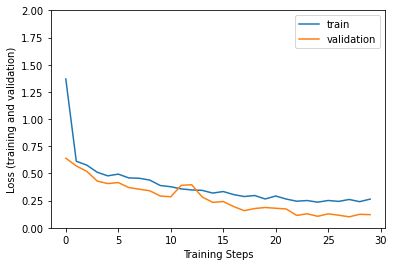

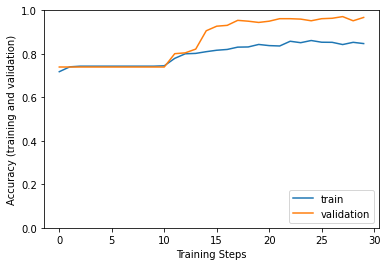

In [18]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(his["loss"])
plt.plot(his["val_loss"])
plt.legend(['train', 'validation'], loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(his["accuracy"])
plt.plot(his["val_accuracy"])
plt.legend(['train', 'validation'], loc='lower right')

testing the model on test set

In [19]:
loss,score = model.evaluate(test_data, test_labels)
print("Test loss:", loss)
print("Test accuracy:", score)

20/20 [==============================] - 7s 337ms/step - loss: 0.8196 - accuracy: 0.7612
Test loss: 0.8195862174034119
Test accuracy: 0.7612179517745972


Confusion matrix & recall/precision

Precision:  0.7339805825242719
Recall:  0.9692307692307692


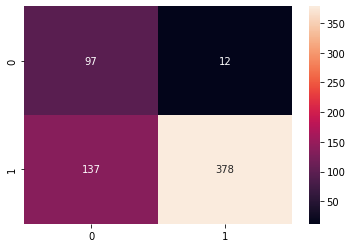

In [20]:
y_pred=np.argmax(model.predict(test_data), axis=-1)# for softmax
y_true=np.argmax(test_labels,axis=1)

precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

print('Precision: ',precision)
print('Recall: ',recall)

cm = confusion_matrix(y_pred,y_true)
f = sns.heatmap(cm, annot=True, fmt='d')

# DenseNet 121

In [11]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [12]:
base_model2 = keras.applications.DenseNet121(weights='imagenet',
                                         include_top=False,
                                         input_shape=input_shape)

base_model2.trainable=False #freeze the model layers
        
base_model2.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 305, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 150, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [13]:
for layer in base_model2.layers:
      if layer.name == 'conv4_block17_2_conv' or layer.name == 'conv4_block17_1_conv ':
        layer.trainable = True


In [14]:
base_model2.get_config()

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 299, 3),
    'dtype': 'float32',
    'name': 'input_1',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'ZeroPadding2D',
   'config': {'data_format': 'channels_last',
    'dtype': 'float32',
    'name': 'zero_padding2d',
    'padding': ((3, 3), (3, 3)),
    'trainable': False},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'zero_padding2d'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'linear',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 64,
    'groups': 1,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 

In [15]:
last_layer = base_model2.get_layer('relu')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(2, activation='softmax')(x)           

model2 = Model(base_model2.input, x) 

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 305, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 150, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [16]:
batch_size = 16
epochs = 30
lr = 1e-4
adam = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.95)

model2.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [17]:
his = model2.fit(train_data, train_labels, epochs=epochs, validation_split=0.1).history

Epoch 1/10
147/147 [==============================] - 94s 499ms/step - loss: 311.1985 - accuracy: 0.7128 - val_loss: 0.5763 - val_accuracy: 0.7395
Epoch 2/10
147/147 [==============================] - 63s 430ms/step - loss: 0.5709 - accuracy: 0.7433 - val_loss: 0.5737 - val_accuracy: 0.7395
Epoch 3/10
147/147 [==============================] - 63s 430ms/step - loss: 0.5739 - accuracy: 0.7433 - val_loss: 0.5750 - val_accuracy: 0.7395
Epoch 4/10
147/147 [==============================] - 63s 429ms/step - loss: 0.5721 - accuracy: 0.7433 - val_loss: 0.5896 - val_accuracy: 0.7395
Epoch 5/10
147/147 [==============================] - 63s 429ms/step - loss: 0.5732 - accuracy: 0.7433 - val_loss: 0.5736 - val_accuracy: 0.7395
Epoch 6/10
147/147 [==============================] - 63s 429ms/step - loss: 0.5721 - accuracy: 0.7433 - val_loss: 0.5748 - val_accuracy: 0.7395
Epoch 7/10
147/147 [==============================] - 63s 430ms/step - loss: 0.5708 - accuracy: 0.7433 - val_loss: 0.5834 - val_

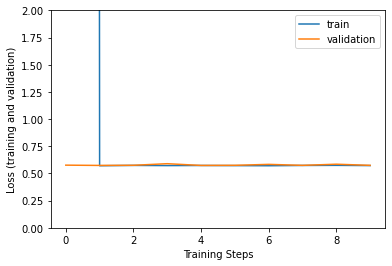

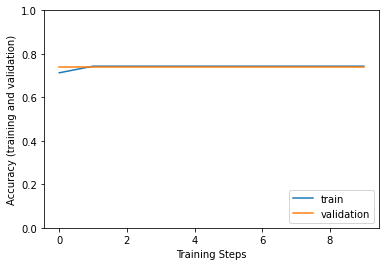

In [18]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(his["loss"])
plt.plot(his["val_loss"])
plt.legend(['train', 'validation'], loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(his["accuracy"])
plt.plot(his["val_accuracy"])
plt.legend(['train', 'validation'], loc='lower right')

In [19]:
loss,score = model2.evaluate(test_data, test_labels)
print("Test loss:", loss)
print("Test accuracy:", score)

20/20 [==============================] - 8s 423ms/step - loss: 0.7044 - accuracy: 0.6250
Test loss: 0.7043718099594116
Test accuracy: 0.625


In [ ]:
y_pred=np.argmax(model2.predict(test_data), axis=-1)# for softmax
y_true=np.argmax(test_labels,axis=1)

precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

print('Precision: ',precision)
print('Recall: ',recall)

cm = confusion_matrix(y_pred,y_true)
f = sns.heatmap(cm, annot=True, fmt='d')

# Part II- Learning rate effect

In [11]:
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import datasets, layers, models, losses, Model

%load_ext tensorboard
HP_learning_rate = hp.HParam('learning rate',hp.Discrete([0.1,0.001,0.00001]))

In [12]:
base_model3 = keras.applications.DenseNet121(weights='imagenet',
                                         include_top=False,
                                         input_shape=input_shape)

base_model3.trainable=False #freeze the model layers

for layer in base_model3.layers:
      if layer.name == 'conv4_block17_2_conv' or layer.name == 'conv4_block17_1_conv ':
        layer.trainable = True

In [13]:
last_layer = base_model3.get_layer('relu')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(2, activation='softmax')(x)           

model3 = Model(base_model3.input, x)

In [14]:
def train_model(hparams,logdir,x_train, y_train):

  adam = keras.optimizers.Adam(learning_rate=hparams[HP_learning_rate], beta_1=0.9, beta_2=0.95)

  model3.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

  hist = model3.fit(x_train, y_train, epochs=3,batch_size=16,validation_split=0.1,callbacks=[tf.keras.callbacks.TensorBoard(logdir),hp.KerasCallback(logdir, hparams)])  
  
  return hist

In [ ]:
session_num = 0
for lr in HP_learning_rate.domain.values:
      hparams = {
        HP_learning_rate: lr,
      }
      run_name = "run-%d" % session_num
      logdir = 'logs/hparam_tuning/' + run_name
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      hist = train_model(hparams,logdir,train_data, train_labels)
      session_num += 1

--- Starting trial: run-0
{'learning rate': 1e-05}
Epoch 1/3
294/294 [==============================] - 102s 271ms/step - loss: 0.2152 - accuracy: 0.9159 - val_loss: 0.0792 - val_accuracy: 0.9770
Epoch 2/3
294/294 [==============================] - 73s 250ms/step - loss: 0.0895 - accuracy: 0.9659 - val_loss: 0.0635 - val_accuracy: 0.9770
Epoch 3/3
294/294 [==============================] - 68s 232ms/step - loss: 0.0708 - accuracy: 0.9744 - val_loss: 0.0673 - val_accuracy: 0.9847
--- Starting trial: run-1
{'learning rate': 0.001}


In [ ]:
%tensorboard --logdir logs/hparam_tuning

# Part III - Class Weight

In [11]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [12]:
class_weight= {0:1.95, 1:0.67}

base_model3 = keras.applications.DenseNet121(weights='imagenet',
                                         include_top=False,
                                         input_shape=input_shape)

base_model3.trainable=False #freeze the model layers
        
base_model3.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 305, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 150, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [13]:
for layer in base_model3.layers:
      if layer.name == 'conv4_block17_2_conv' or layer.name == 'conv4_block17_1_conv ':
        layer.trainable = True

                                                                                                  
 conv5_block14_1_bn (BatchNorma  (None, 7, 9, 128)   512         ['conv5_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block14_1_relu (Activati  (None, 7, 9, 128)   0           ['conv5_block14_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block14_2_conv (Conv2D)  (None, 7, 9, 32)     36864       ['conv5_block14_1_relu[0][0]']   
                                                                                                  
 conv5_block14_concat (Concaten  (None, 7, 9, 960)   0           ['conv5_block13_concat[0][0]',   
 ate)     

In [14]:
last_layer = base_model3.get_layer('relu')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(2, activation='softmax')(x)           

model3 = Model(base_model3.input, x) 

In [15]:
batch_size = 16
epochs = 30
lr = 1e-4
adam = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.95)

model3.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [16]:
his = model3.fit(train_data, train_labels, epochs=epochs, validation_split=0.1,class_weight=class_weight).history

Epoch 1/30
147/147 [==============================] - 89s 472ms/step - loss: 0.2615 - accuracy: 0.9116 - val_loss: 0.1027 - val_accuracy: 0.9636
Epoch 2/30
147/147 [==============================] - 60s 410ms/step - loss: 0.0879 - accuracy: 0.9666 - val_loss: 0.0630 - val_accuracy: 0.9789
Epoch 3/30
147/147 [==============================] - 60s 409ms/step - loss: 0.0624 - accuracy: 0.9774 - val_loss: 0.0726 - val_accuracy: 0.9770
Epoch 4/30
147/147 [==============================] - 60s 410ms/step - loss: 0.0688 - accuracy: 0.9776 - val_loss: 0.0768 - val_accuracy: 0.9751
Epoch 5/30
147/147 [==============================] - 60s 410ms/step - loss: 0.0347 - accuracy: 0.9874 - val_loss: 0.0579 - val_accuracy: 0.9847
Epoch 6/30
147/147 [==============================] - 60s 410ms/step - loss: 0.0395 - accuracy: 0.9870 - val_loss: 0.0928 - val_accuracy: 0.9789
Epoch 7/30
147/147 [==============================] - 60s 409ms/step - loss: 0.0252 - accuracy: 0.9908 - val_loss: 0.0763 - val_ac

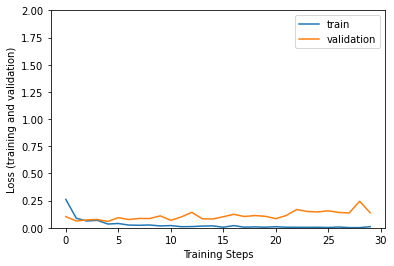

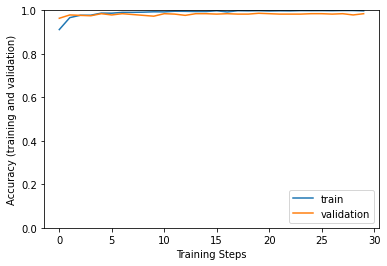

In [17]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(his["loss"])
plt.plot(his["val_loss"])
plt.legend(['train', 'validation'], loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(his["accuracy"])
plt.plot(his["val_accuracy"])
plt.legend(['train', 'validation'], loc='lower right')

In [18]:
loss,score = model3.evaluate(test_data, test_labels)
print("Test loss:", loss)
print("Test accuracy:", score)

20/20 [==============================] - 8s 398ms/step - loss: 1.8685 - accuracy: 0.8606
Test loss: 1.8684923648834229
Test accuracy: 0.8605769276618958


Precision:  0.821656050955414
Recall:  0.9923076923076923


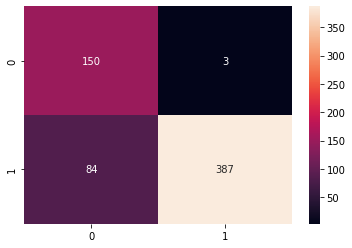

In [19]:
y_pred=np.argmax(model3.predict(test_data), axis=-1)# for softmax
y_true=np.argmax(test_labels,axis=1)

precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

print('Precision: ',precision)
print('Recall: ',recall)

cm = confusion_matrix(y_pred,y_true)
f = sns.heatmap(cm, annot=True, fmt='d')